# Aperiodic electrophysiological activity tracks spiking statistics between behavioral states
Sawyer Figueroa, Michael Preston, Bradley Voytek

# SfN 2023, Poster Panel 
This notebook reproduces the figures from poster panel 5. Panel 5 investigates the relationship between spike-synchrony and aperiodic LFP activity. Spiking and spectral parameters are quantified with high temporal resolution in order to elucidate dynamic changes on the timescale of miliseconds. 

#

Dataset: Allen Institute for Brain Science: Visual Coding - Neuropixels  
© 2015 Allen Institute for Brain Science. Allen Brain Atlas API. Available from: https://portal.brain-map.org/explore/circuits/visual-coding-neuropixels

## Set-up

### set paths

In [1]:
# set paths
PROJECT_PATH = "G:/Shared drives/visual_encoding" # shared results directory
MANIFEST_PATH = 'D:/datasets/allen_vc' # path to manifest file and local dataset

### imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Imports
import pandas as pd
import numpy as np
import neo
import quantities as pq
from elephant.statistics import instantaneous_rate
from elephant import kernels
import matplotlib.pyplot as plt
from matplotlib import rcParams
import sys
import os
import contextlib
from time import time as timer

In [10]:
# custom imports
import sys
sys.path.append('../../')

from allen_vc.plots import plot_linregress, plot_time_resolved_params, error_scatter_plot
from allen_vc.utils import print_time_elapsed
from allen_vc.analysis import compute_pyspike_metrics
from allen_vc.stats import mixedLM

print("Packages Imported")

Packages Imported


### settings

In [7]:
# matplotlib and figure appearance settings
plt.style.use(f'../../stylelib/sfn_2023.mplstyle')
# COLORS = ["#7570b3", "#3FAA96", "#F39943"]

### load data

In [8]:
# concatenate param data
dfs = []
for file in os.listdir(f'{PROJECT_PATH}/data/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/by_session'):
    dfs.append(pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/by_session/{file}'))

all_chans = pd.concat(dfs)

FYI: The above results can typically be imported directly '<project_path>/lfp_data/params/tfr/<stim_code>/lfp_params.csv'

## Main

### Compute time-resolved spike and pupil metrics

In [39]:
# # median across channels
# params = all_chans.groupby(['session', 'epoch_idx', 'window_idx']).median().drop(['chan_idx'], axis=1).reset_index()
# params.head()

In [40]:
# # use sliding window with same window size used for param calculation
# window_size = 0.02*pq.s
# region = 'VISp'

# # init - add results to params dataframe
# params['inst_spike_rate'] = np.nan
# params['avg_pupil_area'] = np.nan
# params['spike_distance'] = np.nan

# # time it
# start = timer()

# # loop over sessions
# for i_ses, ses_id in enumerate(params['session'].unique()):
#     print(f"Computing session: {ses_id} ({i_ses+1}/{len(params['session'].unique())})")

#     # load session data
#     block = neo.io.NeoMatlabIO(f'{PROJECT_PATH}/data/blocks/segmented/natural_movie_one_more_repeats/block_{ses_id}.mat').read_block()
#     seg = block.segments[0]
#     spiketrains = seg.filter({'brain_structure': region}, objects=neo.SpikeTrain) # get only region units
    
#     # init
#     seg_pupil_area = []
#     spk_dist = []
#     i = seg.annotations['stimulus_onset']*pq.s
    
#     # loop over sliding window
#     while i <= seg.t_stop - window_size:
        
#         # calculate average pupil area over window
#         if len(seg.analogsignals) > 1:
#             seg_pupil_area.append(np.mean(seg.analogsignals[1].time_slice(i, i+window_size)))
#         else:
#             seg_pupil_area.append(np.nan)
            
#         # calculate spike distance over interval
#         with contextlib.redirect_stdout(None): # suppress spk.spike_distance output
#             if len(spiketrains) > 1:
#                 spk_dist.append(compute_pyspike_metrics(spiketrains, (i.item(), (i+window_size).item()))[0])
#             else:
#                 spk_dist.append(np.nan)
        
#         # increment window
#         i += window_size
        
#     if len(spiketrains) > 1:
#         seg_rates = instantaneous_rate(spiketrains, sampling_period=0.02*pq.s, kernel=kernels.GaussianKernel(sigma=0.01*pq.s)).magnitude.mean(axis=1)
#     else:
#         seg_rates = [np.nan]*len(spk_dist)

#     # add segment data to params dataframe
#     params.loc[params['session']==ses_id, 'inst_spike_rate'] = seg_rates
#     params.loc[params['session']==ses_id, 'spike_distance'] = spk_dist
#     params.loc[params['session']==ses_id, 'avg_pupil_area'] = seg_pupil_area

# # save/show results
# params.to_csv(f'{PROJECT_PATH}/data/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/params_{region}.csv', index=False)
# print_time_elapsed(start)
# params.head()

In [9]:
# load/concat results from cell above
vis_in = f'{PROJECT_PATH}/data/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/params_VISp.csv'
lgd_in = f'{PROJECT_PATH}/data/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/params_LGd.csv'
params = pd.concat([pd.read_csv(vis_in).assign(brain_structure='VISp'), pd.read_csv(lgd_in).assign(brain_structure='LGd')]).dropna(axis=0,subset=['avg_pupil_area', 'inst_spike_rate','exponent','offset']) # drop null values for pupil area and spike rate
params['session'] = params['session'].astype(str)
params.head()

,session,epoch_idx,window_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,...,bw_2,cf_3,pw_3,bw_3,error,r_squared,inst_spike_rate,avg_pupil_area,spike_distance,brain_structure
0,766640955,1,0,-4.115208,9.968530,2.423561,64.467576,1.233282,9.732393,94.041406,...,5.113630,132.435563,1.289509,10.118157,0.330113,0.885538,3.479088,0.002671,0.211924,VISp
1,766640955,1,1,-3.954905,11.661401,2.582745,63.642010,1.232250,7.163074,99.365796,...,5.786398,131.225242,1.119601,11.121559,0.320669,0.891436,7.116836,0.002669,0.216571,VISp
2,766640955,1,2,-3.810811,7.437185,2.646690,61.905297,1.044139,19.982444,114.950307,...,7.544635,132.205563,1.122866,10.364844,0.302633,0.903953,10.586037,0.002682,0.220487,VISp
3,766640955,1,3,-3.675141,9.884550,2.679084,61.592062,1.109199,5.776820,73.793539,...,12.379198,132.435563,1.193891,11.217565,0.304857,0.901293,11.181677,0.002681,0.233542,VISp
4,766640955,1,4,-3.742768,9.195486,2.637796,49.367178,1.149908,5.723401,74.629031,...,6.158769,131.744733,1.130073,12.123564,0.318002,0.898060,14.245542,0.002670,0.242386,VISp


### Plot results

In [10]:
help(plot_linregress)

Help on function plot_linregress in module allen_vc.plots:

plot_linregress(df, x_data, y_data, group=None, multireg=False, title=None, legend=False, fname_out=None, show=False, close=False)
    Calculate and plot the linear regression of two columns in a dataframe.
    
    Parameters
    ----------
    x_data : str
        column with x-values of dataset
    y_data : str
        column with y-values of dataset
    group: str, optional
        column to color/section data by
    multireg: bool, optional
        whether or not to plot regression lines for each group
    title : str, optional
        Title of the plot
    fname_out : str, optional
        Filename of the output figure
    show : bool, optional
        Whether to show the figure or not
    close : bool, optional
        Whether to close the figure or not
    
    Returns
    -------
    None



#### Pupil area v. LFP parameters

[Text(0.5, 0, 'pupil area (mm)'), Text(0, 0.5, 'LFP offset')]

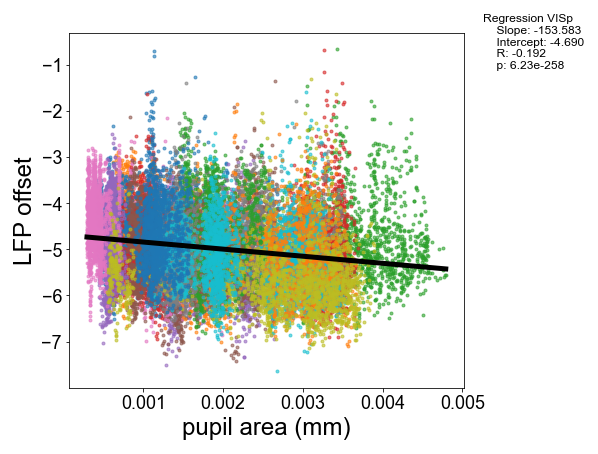

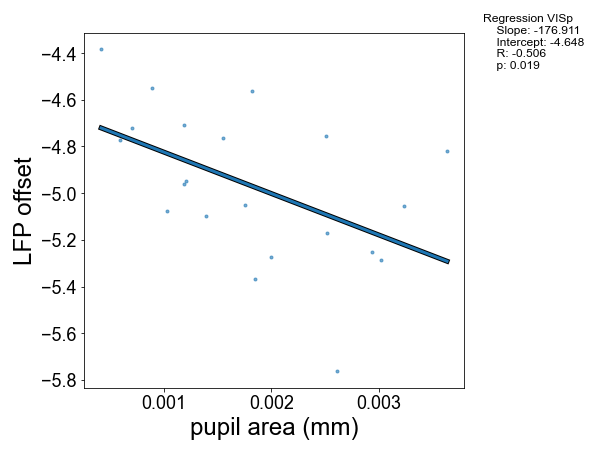

In [19]:
# Pupil area v LFP offset

# plot all data points
df = params.loc[params['brain_structure']=='VISp']
plot_linregress(df, 'avg_pupil_area', 'offset', group='session')
ax = plt.gca()
ax.set(xlabel='pupil area (mm)', ylabel='LFP offset')

# plot session means
df_mean = df.groupby('session').mean().reset_index()
df_mean['brain_structure'] = 'VISp' # add back brain structure to prevent error in plot_linregress
plot_linregress(df_mean, 'avg_pupil_area', 'offset')
ax = plt.gca()
ax.set(xlabel='pupil area (mm)', ylabel='LFP offset')

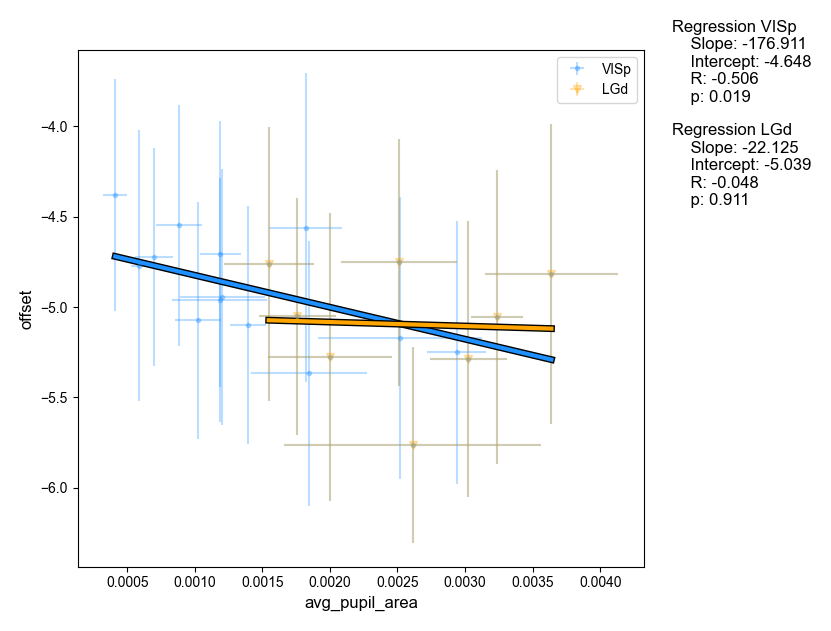

In [41]:
error_scatter_plot(params,'avg_pupil_area', 'offset','session')

[Text(0.5, 0, 'pupil area (mm)'), Text(0, 0.5, 'LFP exponent')]

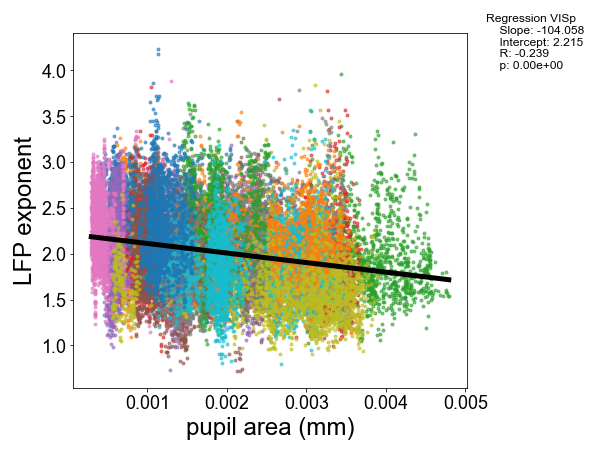

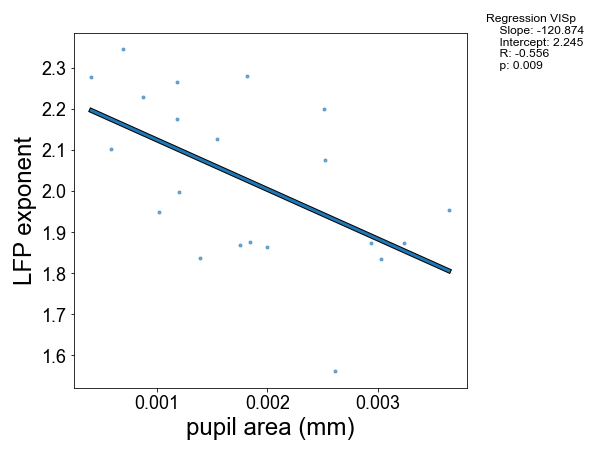

In [21]:
# Pupil area v LFP exponeny

# plot all data points
df = params.loc[params['brain_structure']=='VISp']
plot_linregress(df, 'avg_pupil_area', 'exponent', group='session')
ax = plt.gca()
ax.set(xlabel='pupil area (mm)', ylabel='LFP exponent')

# plot session means
df_mean = df.groupby('session').mean().reset_index()
df_mean['brain_structure'] = 'VISp' # add back brain structure to prevent error in plot_linregress
plot_linregress(df_mean, 'avg_pupil_area', 'exponent')
ax = plt.gca()
ax.set(xlabel='pupil area (mm)', ylabel='LFP exponent')



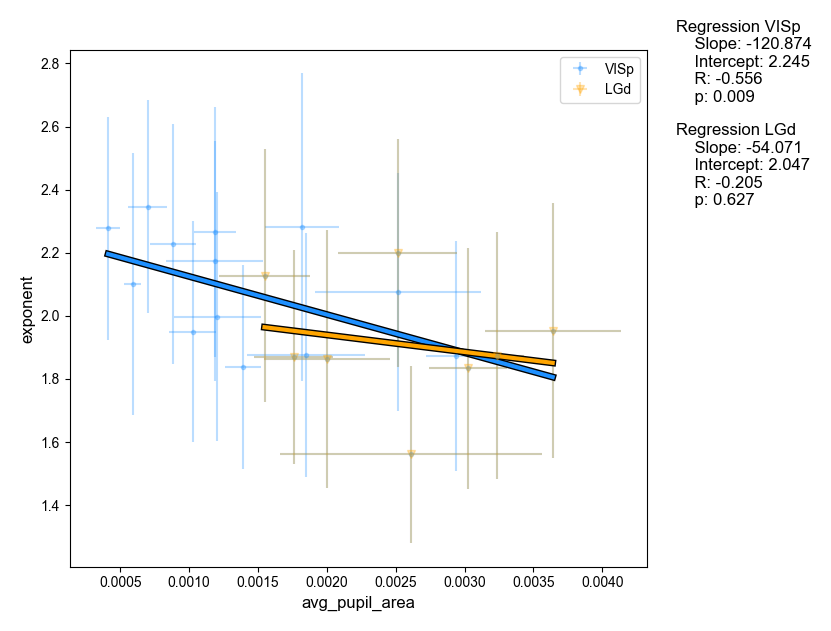

In [42]:
error_scatter_plot(params,'avg_pupil_area', 'exponent','session')

#### Pupil area v. spike metrics

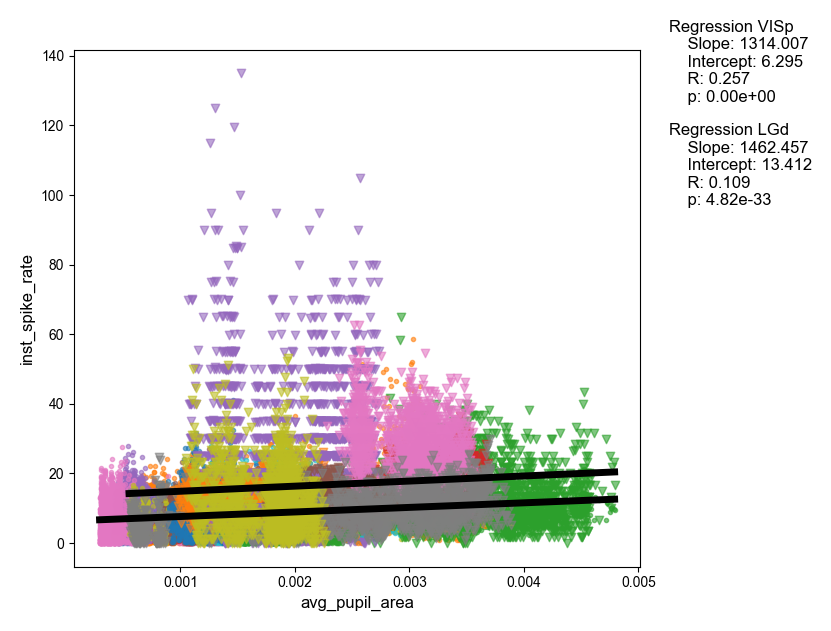

In [64]:
plot_linregress(params, 'avg_pupil_area', 'inst_spike_rate', group='session', show=True)

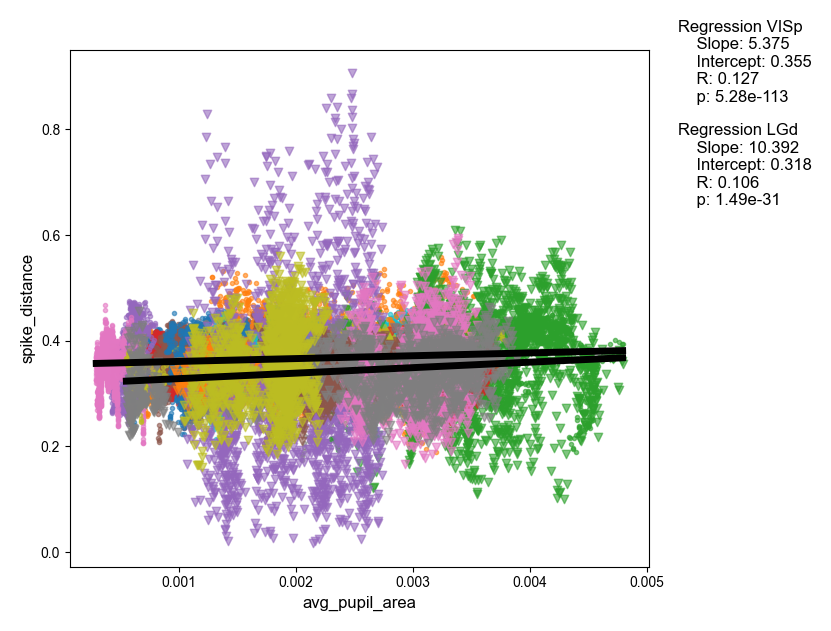

In [65]:
plot_linregress(params, 'avg_pupil_area', 'spike_distance', group='session', show=True)

### Parameter time series

In [75]:
help(plot_time_resolved_params)

Help on function plot_time_resolved_params in module allen_vc.plots:

plot_time_resolved_params(df, session, window, fs, title=None)
    Plot normalized time resolved aperiodic parameters.
    
    Parameters
    ----------
    df : pd.DataFrame
        dataframe containing lfp parameter data.
    session: str
        session from which to draw data.
    window: tuple of ints
        window indices corresponding to the window of data to plot.
    fs: int
        sampling frequency of data.
    title : str, optional
        title of the produced plot
    
    Returns
    -------
    None



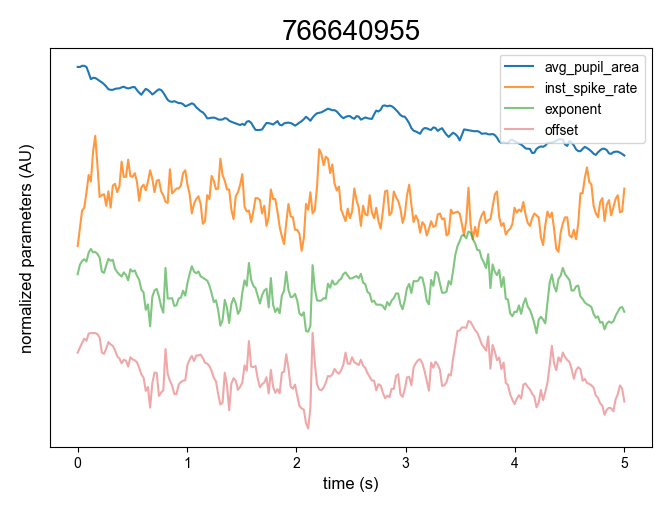

In [74]:
plot_time_resolved_params(params[params['brain_structure']=='VISp'], '766640955', (0,250), 50)

### Statistics

In [ ]:
# linear mixed effect model

In [45]:
# instantaneous spike rate

for region in params['brain_structure'].unique():
    print(region + '\n\n\n')
    region_df = params[params['brain_structure']==region]
    
    mixedLM(region_df, 'inst_spike_rate', ['avg_pupil_area'], 'session')

VISp



            Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: inst_spike_rate
No. Observations:  31500   Method:             REML           
No. Groups:        21      Scale:              18.3714        
Min. group size:   1500    Log-Likelihood:     -90623.1319    
Max. group size:   1500    Converged:          Yes            
Mean group size:   1500.0                                     
--------------------------------------------------------------
                Coef.   Std.Err.   z    P>|z|  [0.025  0.975] 
--------------------------------------------------------------
avg_pupil_area 1113.716   65.360 17.040 0.000 985.613 1241.818
Group Var        49.329    3.560                              

LGd



            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: inst_spike_rate
No. Observations: 12000   Method:             REML           
No. Groups:       8       Scale:              76.1763        
Min. 

In [46]:
# offset

for region in params['brain_structure'].unique():
    print(region + '\n\n\n')
    region_df = params[params['brain_structure']==region]
    
    mixedLM(region_df, 'offset', ['avg_pupil_area'], 'session')

VISp



           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: offset     
No. Observations:   31500   Method:             REML       
No. Groups:         21      Scale:              0.5188     
Min. group size:    1500    Log-Likelihood:     -34472.9035
Max. group size:    1500    Converged:          Yes        
Mean group size:    1500.0                                 
-----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------
avg_pupil_area -13.937   10.965 -1.271 0.204 -35.428  7.555
Group Var       23.081    9.328                            

LGd



          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: offset     
No. Observations:  12000   Method:             REML       
No. Groups:        8       Scale:              0.5418     
Min. group size:   1500    Log-Likelihood:     -13

In [47]:
# exponent

for region in params['brain_structure'].unique():
    print(region + '\n\n\n')
    region_df = params[params['brain_structure']==region]
    
    mixedLM(region_df, 'exponent', ['avg_pupil_area'], 'session')

VISp



          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: exponent   
No. Observations:  31500   Method:             REML       
No. Groups:        21      Scale:              0.1437     
Min. group size:   1500    Log-Likelihood:     -14249.1404
Max. group size:   1500    Converged:          Yes        
Mean group size:   1500.0                                 
----------------------------------------------------------
               Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------
avg_pupil_area -2.067    5.771 -0.358 0.720 -13.379  9.244
Group Var       4.085    3.269                            

LGd



          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: exponent  
No. Observations:   12000   Method:             REML      
No. Groups:         8       Scale:              0.1393    
Min. group size:    1500    Log-Likelihood:     -5238.8006
Max